['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
MT-11020 textures\ABS\MT-11020
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 41.15369290976433
Maximum profile step height, 39.552388934052836
Maximum profile step height, 37.37680691430168
Maximum profile step height, 40.898438461276
Maximum profile step height, 37.94412337961707
Maximum profile step height, 33.817106281520694


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 43.94340723875935
file textures\ABS\MT-11020\MT-11020_spectrum.txt
MT-11020_ABS
MT-11030 textures\ABS\MT-11030
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 52.643349740037294
Maximum profile step height, 44.813971203649565
Maximum profile step height, 43.03781483731753
Maximum profile step height, 42.35128208876593
Maximum profile step height, 42.034850901185834
Maximum profile step height, 42.34587246165103


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 64.79584019875605
file textures\ABS\MT-11030\MT-11030_spectrum.txt
MT-11030_ABS
MT-11040 textures\ABS\MT-11040
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 83.98169762126454
Maximum profile step height, 89.48326034645154
Maximum profile step height, 78.94360878361209
Maximum profile step height, 88.64852904104798
Maximum profile step height, 85.42303900470316
Maximum profile step height, 83.65455801949864


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 117.59919559125329
file textures\ABS\MT-11040\MT-11040_spectrum.txt
MT-11040_ABS
MT-11050 textures\ABS\MT-11050
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 104.63973986006283
Maximum profile step height, 109.46294126040488
Maximum profile step height, 118.52434648128249
Maximum profile step height, 109.71207667119288
Maximum profile step height, 111.0313471452814
Maximum profile step height, 95.41316321456512


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 138.9447102457691
file textures\ABS\MT-11050\MT-11050_spectrum.txt
MT-11050_ABS
MT-11100 textures\ABS\MT-11100
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 167.28509932208405
Maximum profile step height, 168.1901203783836
Maximum profile step height, 201.76240294124224
Maximum profile step height, 176.58955540561143
Maximum profile step height, 175.6291195760821
Maximum profile step height, 170.98410528195427


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 149.74392571924028
file textures\ABS\MT-11100\MT-11100_spectrum.txt
MT-11100_ABS
MT-11110 textures\ABS\MT-11110
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 92.56027237558334
Maximum profile step height, 91.89025601772198
Maximum profile step height, 95.62871315061102
Maximum profile step height, 103.41748846083776
Maximum profile step height, 100.11348385112454
Maximum profile step height, 97.14382168586243


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 156.87155039039357
file textures\ABS\MT-11110\MT-11110_spectrum.txt
MT-11110_ABS
MT-11120 textures\ABS\MT-11120
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 66.14403091145164
Maximum profile step height, 84.87312435860954
Maximum profile step height, 73.45396462038079
Maximum profile step height, 70.0451863429735
Maximum profile step height, 77.67695611296722
Maximum profile step height, 70.4196617176586


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 96.87889853066758
file textures\ABS\MT-11120\MT-11120_spectrum.txt
MT-11120_ABS
MT-11150 textures\ABS\MT-11150
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 87.17741493498917
Maximum profile step height, 106.88671439344927
Maximum profile step height, 105.21774093283751
Maximum profile step height, 75.03848255851035
Maximum profile step height, 88.9555281006931
Maximum profile step height, 92.23066120507721


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 118.68519115131797
file textures\ABS\MT-11150\MT-11150_spectrum.txt
MT-11150_ABS
MT-11160 textures\ABS\MT-11160
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 121.03850113423186
Maximum profile step height, 119.82099393681145
Maximum profile step height, 108.64473232924246
Maximum profile step height, 121.61926326653602
Maximum profile step height, 114.35954141621323
Maximum profile step height, 102.66081526515433


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 124.68716505326205
file textures\ABS\MT-11160\MT-11160_spectrum.txt
MT-11160_ABS
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
MT-11020 textures\PP\MT-11020
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 45.08361102992238
Maximum profile step height, 42.60165447798957
Maximum profile step height, 46.05986836780855
Maximum profile step height, 45.45407088679953
Maximum profile step height, 47.32399085194871
Maximum profile step height, 43.66787770135674


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 67.53211944884075
file textures\PP\MT-11020\MT-11020_spectrum.txt
MT-11020_PP
MT-11030 textures\PP\MT-11030
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 51.66440131740095
Maximum profile step height, 53.309495948539315
Maximum profile step height, 53.9234416398868
Maximum profile step height, 51.82005912823905
Maximum profile step height, 56.88154689229389
Maximum profile step height, 63.806010153139496


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 77.70012112428581
file textures\PP\MT-11030\MT-11030_spectrum.txt
MT-11030_PP
MT-11040 textures\PP\MT-11040
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 86.18368411279818
Maximum profile step height, 94.6752791178555
Maximum profile step height, 111.30903651946687
Maximum profile step height, 88.45697655558409
Maximum profile step height, 101.49819986474651
Maximum profile step height, 86.25460109612226


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 147.68524351525738
file textures\PP\MT-11040\MT-11040_spectrum.txt
MT-11040_PP
MT-11050 textures\PP\MT-11050
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 121.92980979838563
Maximum profile step height, 101.69975246119526
Maximum profile step height, 109.81470760382453
Maximum profile step height, 111.2751262153053
Maximum profile step height, 114.66560370546881
Maximum profile step height, 109.63493435713384


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 133.67363289226125
file textures\PP\MT-11050\MT-11050_spectrum.txt
MT-11050_PP
MT-11100 textures\PP\MT-11100
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 173.53431322155117
Maximum profile step height, 162.287968844876
Maximum profile step height, 149.15981781817248
Maximum profile step height, 169.4960974511606
Maximum profile step height, 168.0946246764792
Maximum profile step height, 162.69072448571185


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 148.5582569335057
file textures\PP\MT-11100\MT-11100_spectrum.txt
MT-11100_PP
MT-11110 textures\PP\MT-11110
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 102.88314134038016
Maximum profile step height, 100.85998806059979
Maximum profile step height, 107.94048114196808
Maximum profile step height, 132.06717094331157
Maximum profile step height, 114.67566274678606
Maximum profile step height, 101.315053967999


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 153.69432196868908
file textures\PP\MT-11110\MT-11110_spectrum.txt
MT-11110_PP
MT-11120 textures\PP\MT-11120
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 70.21499116809316
Maximum profile step height, 74.67397872773088
Maximum profile step height, 65.89655253802823
Maximum profile step height, 70.84897813493136
Maximum profile step height, 74.08902208716044
Maximum profile step height, 68.1955673582418


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 113.82261014237989
file textures\PP\MT-11120\MT-11120_spectrum.txt
MT-11120_PP
MT-11150 textures\PP\MT-11150
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 80.17188862880028
Maximum profile step height, 83.29401163837974
Maximum profile step height, 82.06853704516021
Maximum profile step height, 85.58042964870617
Maximum profile step height, 83.55741986266207
Maximum profile step height, 81.14755035699059


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 121.20118898143512
file textures\PP\MT-11150\MT-11150_spectrum.txt
MT-11150_PP
MT-11160 textures\PP\MT-11160
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Maximum profile step height, 105.56281990235546
Maximum profile step height, 111.54352629606521
Maximum profile step height, 127.05545517180572
Maximum profile step height, 125.40112961320457
Maximum profile step height, 129.26129935113082
Maximum profile step height, 154.14594818335857


C:\Users\diogo\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Maximum spectrum step height, 140.4416448819951
file textures\PP\MT-11160\MT-11160_spectrum.txt
MT-11160_PP
{'MT-11020_ABS': 'textures\\ABS\\MT-11020\\MT-11020_spectrum.txt', 'MT-11030_ABS': 'textures\\ABS\\MT-11030\\MT-11030_spectrum.txt', 'MT-11040_ABS': 'textures\\ABS\\MT-11040\\MT-11040_spectrum.txt', 'MT-11050_ABS': 'textures\\ABS\\MT-11050\\MT-11050_spectrum.txt', 'MT-11100_ABS': 'textures\\ABS\\MT-11100\\MT-11100_spectrum.txt', 'MT-11110_ABS': 'textures\\ABS\\MT-11110\\MT-11110_spectrum.txt', 'MT-11120_ABS': 'textures\\ABS\\MT-11120\\MT-11120_spectrum.txt', 'MT-11150_ABS': 'textures\\ABS\\MT-11150\\MT-11150_spectrum.txt', 'MT-11160_ABS': 'textures\\ABS\\MT-11160\\MT-11160_spectrum.txt', 'MT-11020_PP': 'textures\\PP\\MT-11020\\MT-11020_spectrum.txt', 'MT-11030_PP': 'textures\\PP\\MT-11030\\MT-11030_spectrum.txt', 'MT-11040_PP': 'textures\\PP\\MT-11040\\MT-11040_spectrum.txt', 'MT-11050_PP': 'textures\\PP\\MT-11050\\MT-11050_spectrum.txt', 'MT-11100_PP': 'textures\\PP\\MT-11100\\M

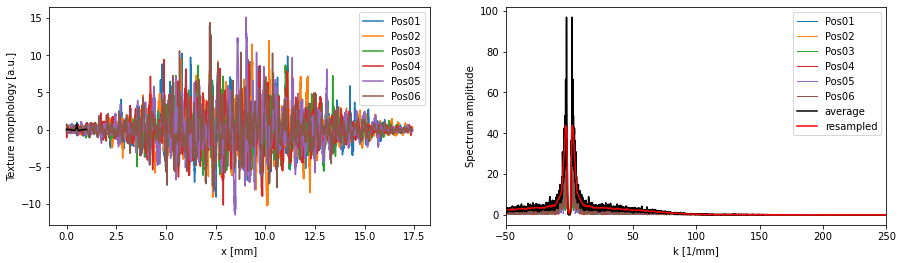

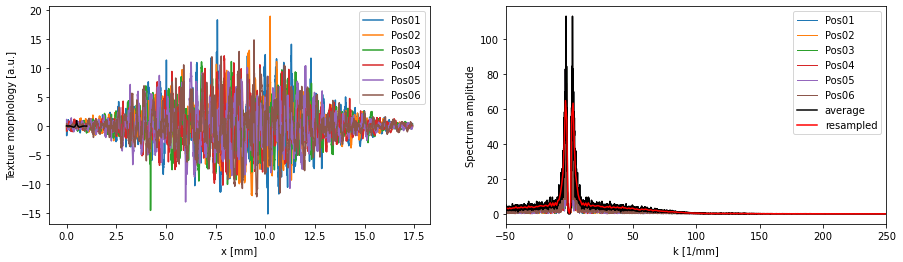

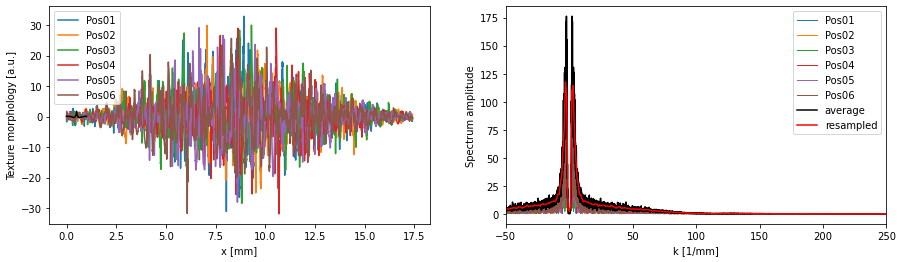

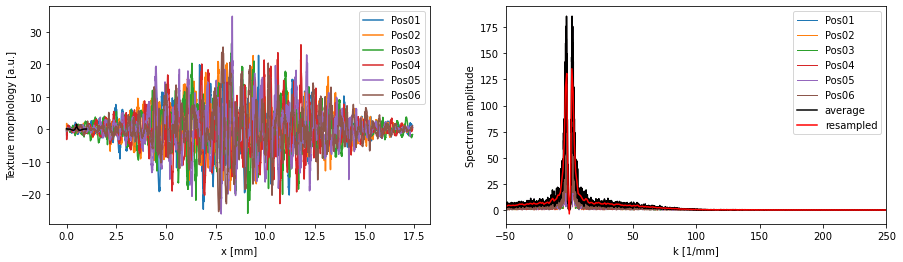

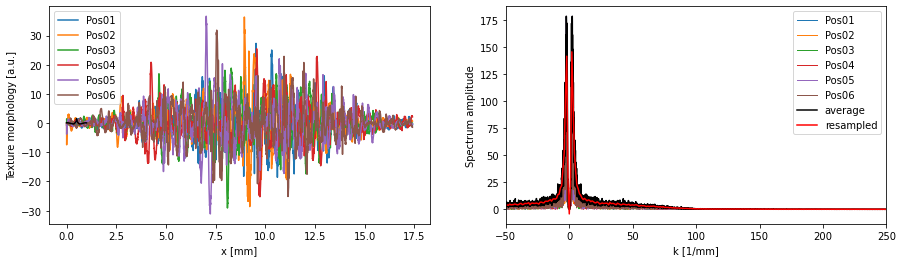

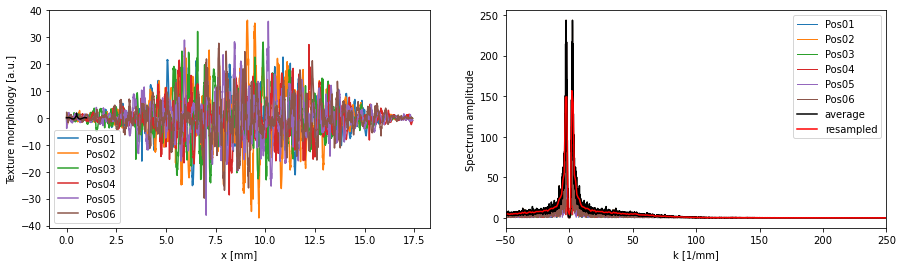

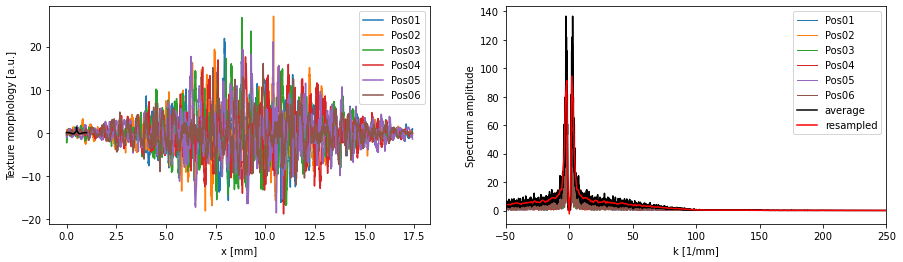

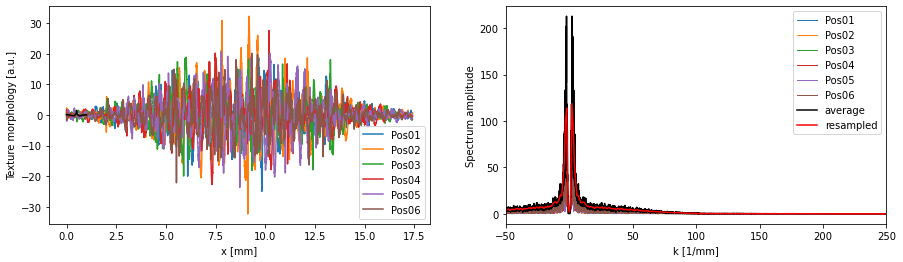

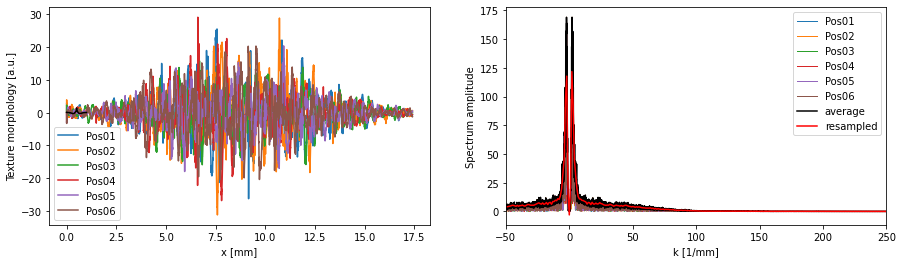

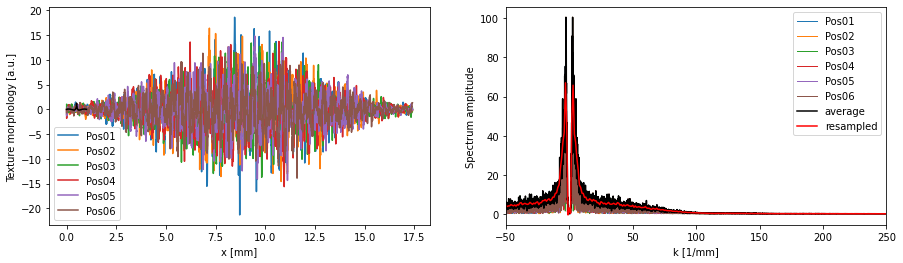

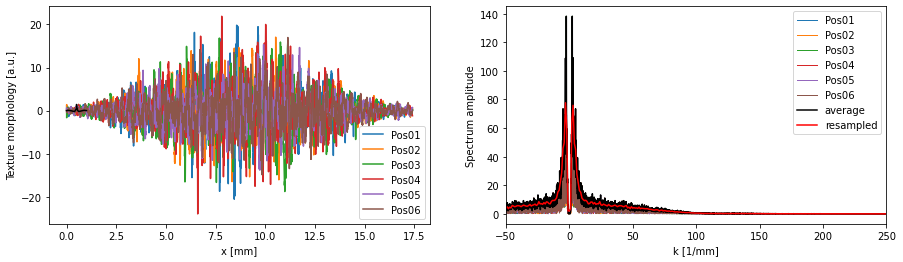

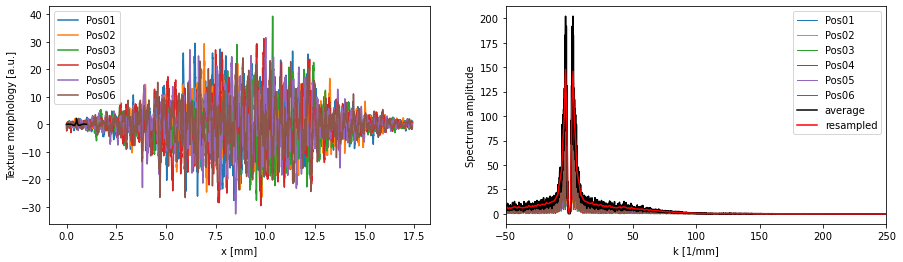

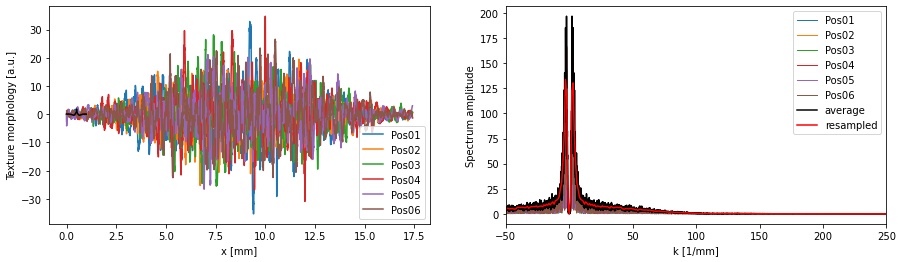

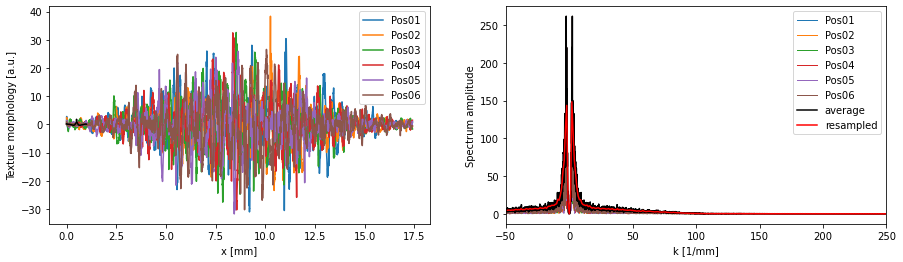

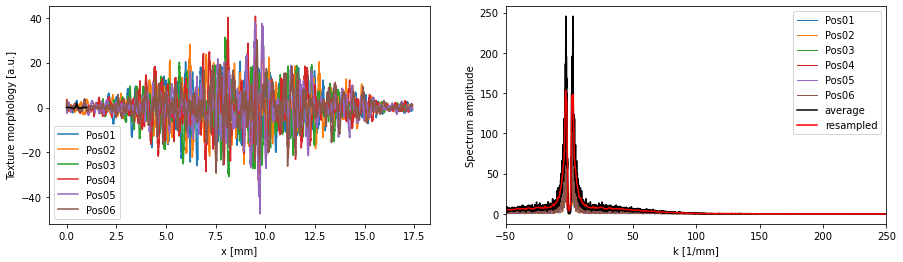

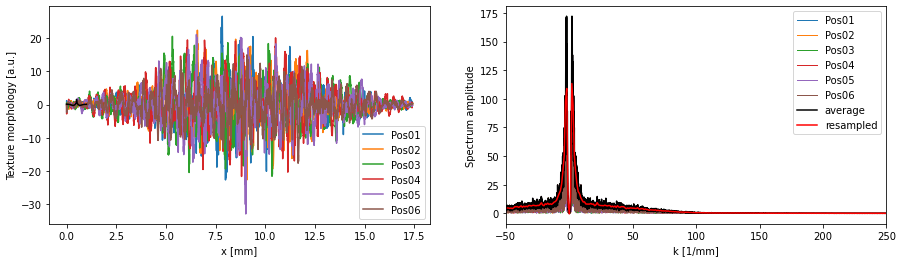

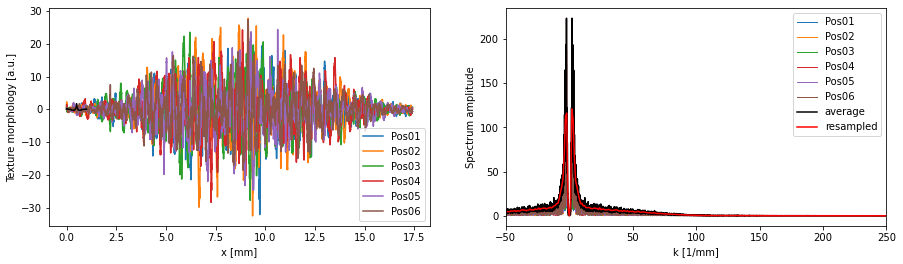

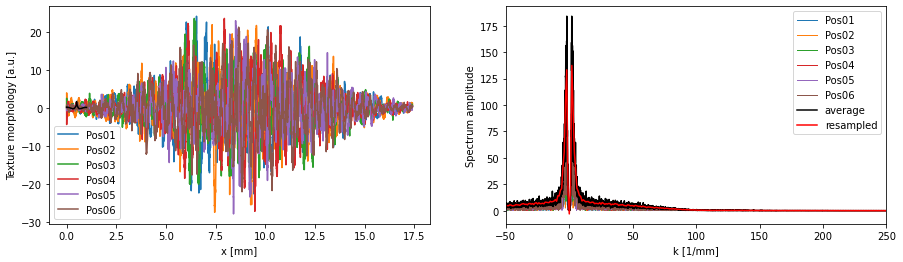

In [39]:
from  texture_vibration_generator import *
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal



sample ="MT-11020"

path = "textures\\ABS\\"

directories = os.listdir(path)

print(directories)
directories = [file for file in directories if os.path.isdir(os.path.join(path,file))]
print(directories)

sample_names = directories

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



N_spectrum = 1000
N_spectrum = 17501

cutoff_fine_texture = 2 # peaks /mm


output_N_spectrum = 512*2
output_fs_spatial = 512*2 # samples/mm

# for path_name in [os.path.join(path, sample) for sample in sample_names]:

json_dictionary = dict()

for material in ['ABS', 'PP']:
    
    path = "textures\\%s\\"%(material)

    directories = os.listdir(path)

    print(directories)
    directories = [file for file in directories if os.path.isdir(os.path.join(path,file))]
    print(directories)

    sample_names = directories
    for sample in sample_names:
        path_name = os.path.join(path, sample) 
        print(sample, path_name)

        # listing all profile names inside
        files = os.listdir(path_name)


        # select the proper extension
        files = [file for file in files if ".ua2" in file]
        print(files)


        fig, ax = plt.subplots(1,2, figsize=(15,4))


        profile_list = []
        profile_x_list = []

        spectrum_list = []
        spectrum_freqs_list = []
        for file in files:
            filename = os.path.join(path_name, file)
    #         print(filename)

            # load the resolution:
            with open(filename, "r") as f:
                line = f.readline()
                if "Profil" not in line:
                    break
                else:
                    line = f.readline()

                    # Read the x-length and x-resolution
                    # example line: X-Maß = 17.50 X-Auflösung = 1000.00 Punkte/Zeile: 17501
                    data = re.findall(r"[-+]?\d*\.\d+|\d+", line)
    #                 print(line)
                    x_length, x_resolution, x_total = [float(value) for value in data]
#                     print(file, x_length, x_resolution, x_total)

            # Load all the profile data and construct the x and y topography
            profile = np.loadtxt(filename, skiprows=2)

            assert profile.size == x_total, "Confirm that the profile size is the same as the extracted x_total in the .ua2 header"


            # trim to a multiple of the output_N_spectrum
            profile = profile[:np.floor_divide(profile.size, output_N_spectrum)*output_N_spectrum]


            x_total = profile.size
            fs_spatial = x_resolution

        
            resample_num = np.int(output_fs_spatial/fs_spatial*x_total)

            profile = signal.resample(profile, resample_num)
            fs_spatial = output_fs_spatial
            x_total = profile.size



            x = np.linspace(0, x_total/fs_spatial, x_total)
    #         x = np.linspace(0,x_length, profile.size)

            # Detrend the profile lienarly
            profile = signal.detrend(profile, type='linear')
            
            
            # calculate maximum profile peak-peak
            profile_ptp = np.ptp(profile)
            print("Maximum profile step height,", profile_ptp)
            
            
            
            # high pass filter
            
            order = 5
            fs = fs_spatial
            
            
            lowcut = cutoff_fine_texture
#             lowcut = 1
            highcut = 256

#             profile = butter_bandpass_filter(profile,lowcut, highcut, fs_spatial, order=order)
            
    
            b,a = butter_bandpass(lowcut, highcut, fs_spatial, order=order)
            zf = signal.lfiltic(b,a, profile)
            profile = signal.lfilter(b, a, profile,)
#             print(zf)
#             profile, zf = signal.lfilter(b, a, profile, zi=zf)

#             profile = butter_highpass_filter(profile, cutoff_fine_texture, fs, order)

            
            
            # trim the profile to a multiple of output_N_spectrum
            # profile = profile - np.mean(profile)
            
            # windowing
            window = np.hamming(profile.size)
            profile *= window

            
            # Calculate the spectrum from the profile
            spectrum_profile = np.fft.fft(profile, norm='ortho')

            spectrum_spatial_freq = np.fft.fftfreq(spectrum_profile.size, d=np.diff(x)[0])

            # Absolute of the profile
            spectrum_profile = np.abs(spectrum_profile)
            
            # Shift everything to center
            spectrum_profile = np.fft.fftshift(spectrum_profile)
            spectrum_spatial_freq = np.fft.fftshift(spectrum_spatial_freq)
            



            # append profile and spectrum profile to the list for post averaging
            profile_list.append(profile)
            profile_x_list.append(x)
            spectrum_list.append(spectrum_profile)
            spectrum_freqs_list.append(spectrum_spatial_freq)


            posfilename = os.path.splitext(file)[0]
            
            # Plot each profile
            plt.sca(ax[0])

            plt.plot(x, profile, label=posfilename)
            plt.xlabel("x [mm]")
            plt.ylabel("Texture morphology [a.u.]")

            plt.legend()
            plt.sca(ax[1])

            plt.plot(spectrum_spatial_freq, np.abs(spectrum_profile), lw=1, label=posfilename)



        plt.sca(ax[1])
    
        # Average all the spectrums
        spectrum_profiles = np.max(spectrum_list, axis=0)
        spectrum_spatial_freqs = np.mean(spectrum_freqs_list, axis=0)
        plt.plot(spectrum_spatial_freqs, spectrum_profiles.real, c='k', label="average")

        # Resample to a specific number of output_N_spectrum=1024. This way all the spectrums have the same size
        spectrum_profiles = signal.resample(spectrum_profiles, num=output_N_spectrum)

        
        
        spectrum_spatial_freqs = np.fft.fftshift(np.fft.fftfreq(spectrum_profiles.size, d=1/fs_spatial))
        plt.plot(spectrum_spatial_freqs, spectrum_profiles.real, c='r', label="resampled")
        plt.xlim(-50,250)
    #     print(spectrum_profiles.size, spectrum_spatial_freqs.max())

        plt.legend()

        plt.xlabel("k [1/mm]")
        plt.ylabel("Spectrum amplitude")

        # Synthesize the texture from spectrum

        plt.sca(ax[0])

        texture_profile = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(spectrum_profiles)))
        texture_x = np.linspace(0, texture_profile.size/fs_spatial, texture_profile.size)
        plt.plot(texture_x, texture_profile, c='k', label="Synthetic texture")



        outputname = "%s_spectrum.png"%(sample)
        output_filename = os.path.join(path_name, outputname)
        plt.savefig(output_filename)

        output_filename_texture = "%s_spectrum.txt"%(sample)

        data = np.array([spectrum_spatial_freqs,spectrum_profiles]).T

        output_filename_texture = "%s_spectrum.txt"%(sample)
        output_filename = os.path.join(path_name, output_filename_texture)


        np.savetxt(output_filename, data, delimiter=',', header='spatial freqs [1/mm], spectrum [a.u.]')    
    #     plt.close()
        print("Maximum spectrum step height,", np.ptp(spectrum_profiles))

        print("file", output_filename)
        
        key_name = "%s_%s"%(sample,material)
        print(key_name)
        json_dictionary[key_name] = output_filename
        
#         break
print(json_dictionary)

path = "textures"
filename_json = os.path.join(path, "textures.json")
with open(filename_json, 'w') as outfile:
    json.dump(json_dictionary, outfile, indent=4)
print('saved texture file to ', filename_json)

17825

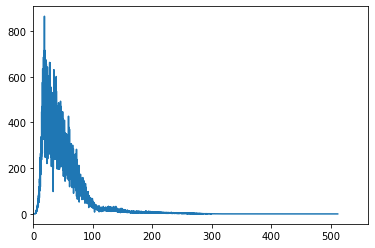

In [5]:
spectrum_profiles = np.mean(spectrum_list, axis=0)
spectrum_spatial_freqs = np.mean(spectrum_freqs_list, axis=0)
plt.plot(spectrum_spatial_freqs, spectrum_profiles)
plt.xlim(xmin=0,)
spectrum_profiles.size

In [6]:
json_filename = os.path.join("textures", "textures.json")


with open(json_filename) as json_file:
    data = json.load(json_file)
    
for key in data:
    print(key, data[key])

MT-11020_ABS textures\ABS\MT-11020\MT-11020_spectrum.txt
MT-11020_PP textures\PP\MT-11020\MT-11020_spectrum.txt


textures\ABS\MT-11020\MT-11020_spectrum.txt
2 400 1024 3
frame 0.7326294707724806 -0.007229628747911153
framefilt 0.7712682251237777 -0.0017528721293498851


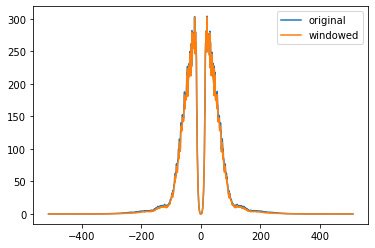

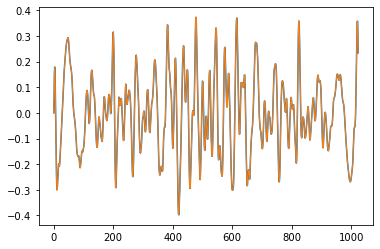

In [26]:
from  texture_vibration_generator import *
texture_name = list(data.keys())[0]
texture_file = data[texture_name]
print(texture_file)


freqs, spectrum = np.loadtxt(texture_file, delimiter=',', unpack=True)


# spectrum  = spectrum-np.mean(spectrum)
# spectrum = np.clip(spectrum,a_min=10, a_max=120)
window = np.hamming(spectrum.size)

easing = window_easing(spectrum.size, 128)

specwin = spectrum*window
plt.plot(freqs, spectrum, label='original')

plt.plot(freqs, specwin, label='windowed')


plt.legend()


plt.figure()
fs_spatial = 1024
velocity_probe = 1
N_frame = spectrum.size*1
fs_audio = fs_spatial
t_frame, sig_frame = estimate_texture_signal(spectrum, fs_spatial, velocity_probe, N_frame, fs_audio, )


sig = generate_audio_from_spectrum(spectrum)
t_frame, sig_frame = estimate_texture_signal(spectrum, fs_spatial, velocity_probe, N_frame, fs_audio, )


sig_frame = sig_frame*window_easing(y.size, 256)

print(2, 400, fs_spatial, order)

print('frame',np.ptp(sig_frame), np.mean(sig_frame))

order = 3
b,a = butter_bandpass(5, 400, fs_spatial, order=order)
sig_frame = signal.lfilter(b, a, sig_frame, )

# sig_frame = sig_frame[:-order]

print('framefilt',np.ptp(sig_frame), np.mean(sig_frame))

sig = sig_frame
y = sig
# y = np.fft.ifft(np.fft.fftshift(spectrum))
# y = np.fft.ifft(spectrum)

# y = np.fft.fftshift(y)
plt.plot(y)

y = np.real(y)



# y = np.fft.fftshift(y)
# y = np.fft.fftshift(y)
# plt.plot(y)

plt.plot(np.concatenate([y]),lw=1)
# plt.plot(y)

# y = np.fft.ifft(np.fft.fftshift(specwin))
# plt.plot(y*window)


# plt.plot(sig_frame)

cutoff = 30
sig_frame = butter_lowpass_filter(sig_frame, cutoff, fs_spatial)
# sig_frame = butter_highpass_filter(sig_frame, cutoff, fs_spatial)
# plt.plot(sig_frame)
# plt.plot(sig_frame*window)
# plt.plot(sig_frame*easing)
# plt.plot(sig_frame*easing*window)


# plt.ylim(-1,1)

# plt.xlim(250,260)

# plt.figure()

# newspec = np.fft.fftshift(np.fft.fft(sig_frame))
# plt.plot(newspec)

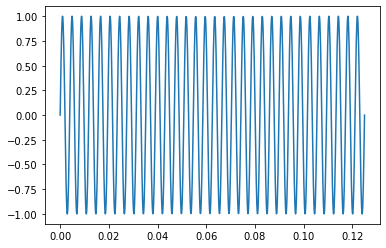

In [51]:
fs_audio = 8192

N_audio_segment = 512*2
t_frame = np.linspace(0, N_audio_segment/fs_audio, fs_audio)
t_frame = np.linspace(0, N_audio_segment/fs_audio, N_audio_segment)
sig_frame = np.sin(2*np.pi*(256)*t_frame)

plt.plot(t_frame, sig_frame)

In [54]:
p.terminate()

In [85]:
import pyaudio



def array2audio(note,max_amplitude=2):
    # Ensure that highest value is in 16-bit range
    audio = note * (2**15 - 1) / max_amplitude
    # Convert to 16-bit data
    audio = audio.astype(np.int16)
    return audio


fs_audio = 8192*4

N_audio_segment = 512*4
CHUNK = N_audio_segment
WIDTH = 2
CHANNELS = 1
RATE = fs_audio
RECORD_SECONDS = 2
FORMAT = pyaudio.paInt16

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=False,
                output=True,
                frames_per_buffer=CHUNK)

#     t_frame = np.linspace(0, N_audio_segment/fs_audio, fs_audio)
t_frame = np.linspace(0, N_audio_segment/fs_audio, N_audio_segment)
sig_frame = np.sin(2*np.pi*(256)*t_frame)
data = array2audio(sig_frame[:])
# data = np.tile(data,2)

print(data[:2], data[:-2])
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):


    
    
    stream.write(data, CHUNK,exception_on_underflow=True)

print("* done")

stream.stop_stream()
stream.close()

p.terminate()

[  0 804] [    0   804  1606 ... -3197 -2405 -1606]
* done


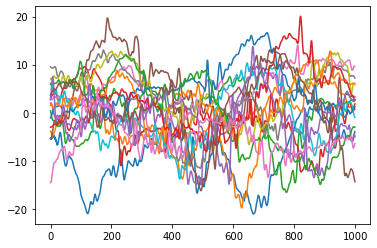

In [3]:
N_spectrum = 1000
profile_split = np.array_split(profile, np.arange(N_spectrum,x_total,N_spectrum).astype(np.int))
profile_split = [p for p in profile_split if p.size==N_spectrum]
[p.shape for p in profile_split]


for p in profile_split:
    plt.plot(p)


['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
['MT-11020', 'MT-11030', 'MT-11040', 'MT-11050', 'MT-11100', 'MT-11110', 'MT-11120', 'MT-11150', 'MT-11160']
MT-11020 textures\ABS\MT-11020
['Pos01.ua2', 'Pos02.ua2', 'Pos03.ua2', 'Pos04.ua2', 'Pos05.ua2', 'Pos06.ua2']
Pos01.ua2 17.5 1000.0 17501.0
done
Pos02.ua2 17.5 1000.0 17501.0
done
Pos03.ua2 17.5 1000.0 17501.0
done
Pos04.ua2 17.5 1000.0 17501.0
done
Pos05.ua2 17.5 1000.0 17501.0
done
Pos06.ua2 17.5 1000.0 17501.0
done
file textures\ABS\MT-11020\MT-11020_spectrum.png


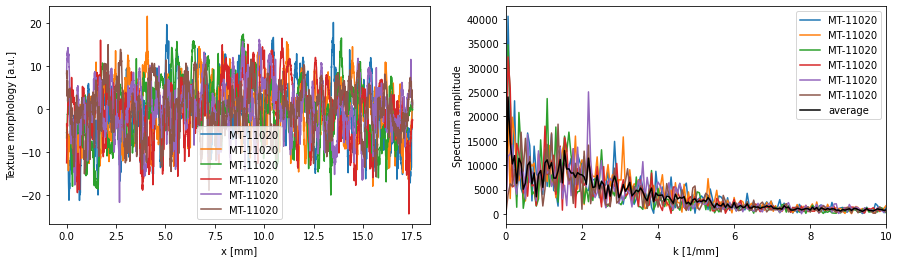

In [20]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal



sample ="MT-11020"


path = "textures\\ABS\\"

directories = os.listdir(path)

print(directories)
directories = [file for file in directories if os.path.isdir(os.path.join(path,file))]
print(directories)

sample_names = directories


N_spectrum = 512
# for path_name in [os.path.join(path, sample) for sample in sample_names]:

for sample in sample_names:
    path_name = os.path.join(path, sample) 
    print(sample, path_name)
    
    # listing all profile names inside
    files = os.listdir(path_name)
    
    
    # select the proper extension
    files = [file for file in files if ".ua2" in file]
    print(files)
    
    
    fig, ax = plt.subplots(1,2, figsize=(15,4))

    
    profile_list = []
    profile_x_list = []
    
    spectrum_list = []
    spectrum_freqs_list = []
    for file in files:
        filename = os.path.join(path_name, file)
#         print(filename)
        
        # load the resolution:
        with open(filename, "r") as f:
            line = f.readline()
            if "Profil" not in line:
                break
            else:
                line = f.readline()
                
                # Read the x-length and x-resolution
                # example line: X-Maß = 17.50 X-Auflösung = 1000.00 Punkte/Zeile: 17501
                data = re.findall(r"[-+]?\d*\.\d+|\d+", line)
#                 print(line)
                x_length, x_resolution, x_total = [float(value) for value in data]
                print(file, x_length, x_resolution, x_total)
        
        # Load all the profile data and construct the x and y topography
        profile = np.loadtxt(filename, skiprows=2)
        
        assert profile.size == x_total, "Confirm that the profile size is the same as the extracted x_total in the .ua2 header"
        x = np.linspace(0,x_length, profile.size)
        
        # Detrend the profile lienarly
        profile = signal.detrend(profile, type='linear')

        # Trim the profile for sequences of N points
        
        
        
        spectrum_profile = np.fft.fft(profile-np.mean(profile))

        spectrum_spatial_freq = np.fft.fftfreq(spectrum_profile.size, d=np.diff(x)[0])

        spectrum_texture = spectrum_profile
        spectrum_profile = np.abs(spectrum_profile)

        spectrum_profile = np.fft.fftshift(spectrum_profile)
        spectrum_spatial_freq = np.fft.fftshift(spectrum_spatial_freq)



        profile_list.append(profile)
        profile_x_list.append(x)
        spectrum_list.append(spectrum_profile)
        spectrum_freqs_list.append(spectrum_spatial_freq)
        
        
        posfilename = os.path.splitext(file)[0]

        plt.sca(ax[0])

        plt.plot(x, profile, label=sample)
        plt.xlabel("x [mm]")
        plt.ylabel("Texture morphology [a.u.]")

        plt.legend()
        plt.sca(ax[1])

#         plt.plot(spectrum_spatial_freq, spectrum_profile/spectrum_profile.max(), label=sample)
        plt.plot(spectrum_spatial_freq, spectrum_profile, label=sample)
        plt.xlim(0,10)
        
      
        
        
        
        print("done")
        
    plt.sca(ax[1])
    spectrum_profiles = np.mean(spectrum_list, axis=0)
    spectrum_spatial_freqs = np.mean(spectrum_freqs_list, axis=0)
    plt.plot(spectrum_spatial_freqs, spectrum_profiles, c='k', label="average")
    plt.xlim(0,10)
    
    plt.legend()

    plt.xlabel("k [1/mm]")
    plt.ylabel("Spectrum amplitude")
 
    outputname = "%s_spectrum.png"%(sample)
    output_filename = os.path.join(path_name, outputname)
    plt.savefig(output_filename)
#     plt.close()
    print("file", output_filename)
    break

17501

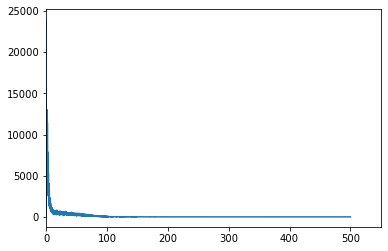